In [1]:
# Set random seeds for reproducibility
import os
import random
import numpy as np
import tensorflow as tf

SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import talib as ta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [3]:
# 1. Data Collection (2019-01-01 to 2020-07-22)
df = yf.download('DBO', start='2019-01-01', end='2020-07-22')
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
print(df.tail())

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Price           Open      High       Low     Close   Volume
Ticker           DBO       DBO       DBO       DBO      DBO
Date                                                       
2020-07-15  6.590265  6.662785  6.535875  6.617460  2144400
2020-07-16  6.599330  6.653720  6.581200  6.590265   766200
2020-07-17  6.599329  6.617459  6.517744  6.599329   828800
2020-07-20  6.554005  6.626525  6.499615  6.590265   687800
2020-07-21  6.762500  6.825955  6.689980  6.717175  1505200


In [4]:
# 2. Feature Engineering
df['MA20'] = df['Close'].rolling(window=20).mean()
df['MA50'] = df['Close'].rolling(window=50).mean()
df['RSI'] = ta.RSI(df['Close'].values.flatten(), timeperiod=14)
df['MACD'], _, _ = ta.MACD(df['Close'].values.flatten())
df.dropna(inplace=True)
df.head()

Price,Open,High,Low,Close,Volume,MA20,MA50,RSI,MACD
Ticker,DBO,DBO,DBO,DBO,DBO,,,,
Date,,,,,,,,,
2019-03-14,9.363770,9.399441,9.301345,9.328098,282300,9.172927,8.819066,64.645239,0.133386
2019-03-15,9.247837,9.345933,9.230002,9.310262,728400,9.191655,8.851348,63.549023,0.132171
2019-03-18,9.319180,9.381606,9.319180,9.354852,753700,9.201019,8.883274,65.140469,0.133270
2019-03-19,9.390523,9.408359,9.310262,9.310262,275100,9.206815,8.910563,62.215213,0.129055
2019-03-20,9.354851,9.479702,9.345933,9.435112,301800,9.217517,8.938744,66.721451,0.134242


In [5]:
# 3. Data Preprocessing
target_col = 'Close'
train_size = int(len(df) * 0.8)
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size-60:]

scaler = MinMaxScaler(feature_range=(0,1))
scaled_train = scaler.fit_transform(train_data)
scaled_test = scaler.transform(test_data)

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])
        y.append(data[i, df.columns.get_loc(target_col)])
    return np.array(X), np.array(y)

SEQ_LENGTH = 60
X_train, y_train = create_sequences(scaled_train, SEQ_LENGTH)
X_test, y_test = create_sequences(scaled_test, SEQ_LENGTH)
print(f"Training shape: {X_train.shape}")
print(f"Testing shape: {X_test.shape}")

Training shape: (213, 60, 9)
Testing shape: (69, 60, 9)


In [6]:
# 4. Build LSTM Model (Adjusted for smoother validation)
from keras.optimizers import Adam

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(25),
    Dense(1)
])

optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='mean_squared_error')
model.summary()


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 64)         │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,625 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,619 (209.45 KB)

 Trainable params: 53,619 (209.45 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Define ModelCheckpoint to save the best model
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(
    filepath='best_lstm_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)


Epoch 1/100
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2884 
Epoch 1: val_loss improved from inf to 0.09161, saving model to best_lstm_model.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.2557 - val_loss: 0.0916
Epoch 2/100
4/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0755
Epoch 2: val_loss improved from 0.09161 to 0.05861, saving model to best_lstm_model.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0760 - val_loss: 0.0586
Epoch 3/100
4/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0347
Epoch 3: val_loss improved from 0.05861 to 0.02352, saving model to best_lstm_model.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0331 - val_loss: 0.0235
Epoch 4/100
4/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0315
Epoch 4: val_loss did not improve from 0.02352
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0317 - val_loss: 0.0255
Epoch 5/100
4/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0214
Epoch 5: val_loss did not improve from 0.02352
6/6 ━━━━━━━━━━━━━━━━━━━━ 0

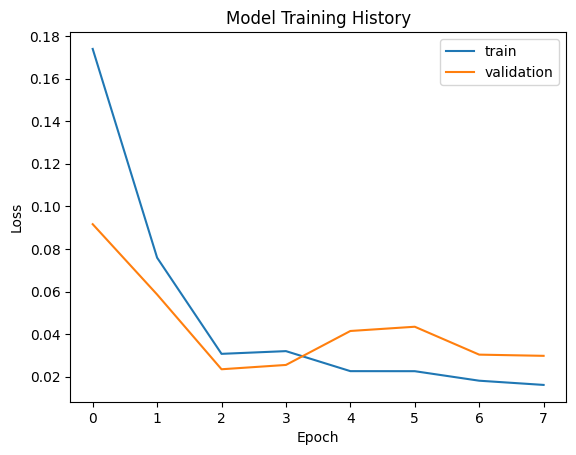

In [8]:
# 5. Train Model
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=100,
    validation_split=0.2,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Model Training History')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [9]:
# 6. Make Predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(
    np.repeat(predictions, scaled_test.shape[1], axis=1)
)[:, df.columns.get_loc(target_col)].ravel()

actuals = scaler.inverse_transform(
    np.repeat(y_test.reshape(-1,1), scaled_test.shape[1], axis=1)
)[:, df.columns.get_loc(target_col)].ravel()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


In [10]:
# Load the best saved model for evaluation
from keras.models import load_model
best_model = load_model('best_lstm_model.keras')


RMSE: 0.52
MAE: 0.39


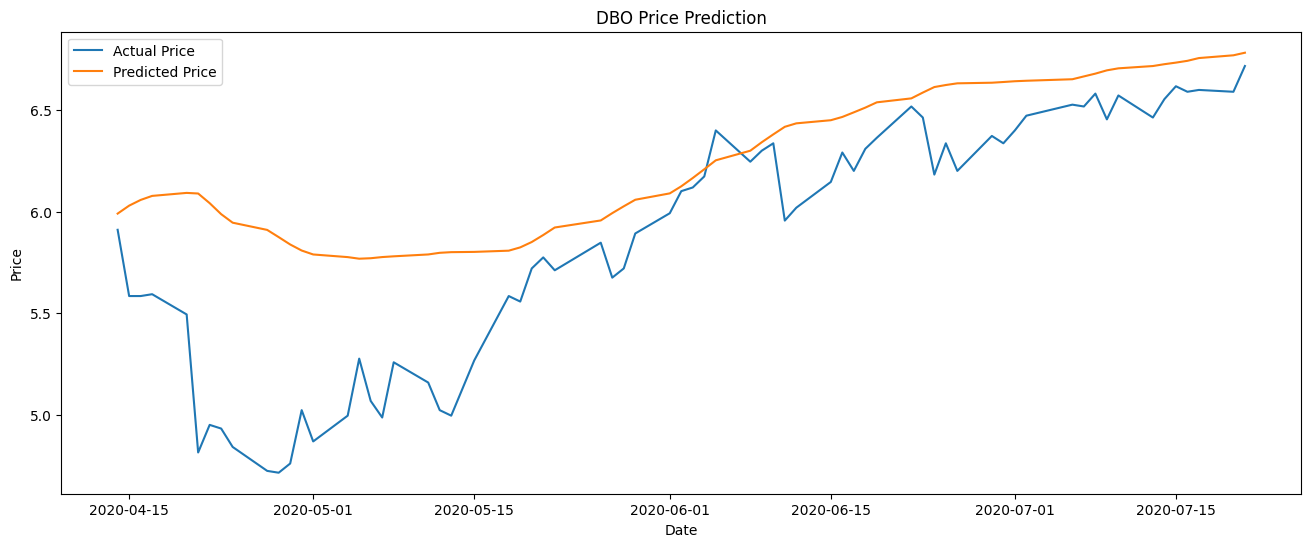

In [11]:
# 7. Evaluate Model
rmse = np.sqrt(mean_squared_error(actuals, predictions))
mae = mean_absolute_error(actuals, predictions)
print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')

# Extract correct time index from original dataframe for X_test
date_index = df.iloc[-len(actuals):].index

# Plot with datetime index
plt.figure(figsize=(16,6))
plt.plot(date_index, actuals, label='Actual Price')
plt.plot(date_index, predictions, label='Predicted Price')
plt.title('DBO Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()
